# Importance of decision tree hyperparameters on generalization

Neste caderno, ilustraremos a importância de algumas
hiperparâmetros na árvore de decisão; vamos demonstrar seus efeitos sobre
os problemas de classificação e regressão que vimos anteriormente.

Primeiro, carregaremos os conjuntos de dados de classificação e regressão.

In [1]:
import pandas as pd

data_clf_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_clf_column = "Species"
data_clf = pd.read_csv("penguins_classification.csv")

In [3]:
data_reg_columns = ["Flipper Length (mm)"]
target_reg_column = "Body Mass (g)"
data_reg = pd.read_csv("penguins_regression.csv")

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last"> Se você quiser uma visão geral mais detalhada sobre este conjunto de dados, pode consultar o
Apêndice - seção de descrição dos conjuntos de dados no final deste MOOC. </p>
</div>

## Criar funções auxiliares

Vamos criar duas funções que irão:

* ajustar uma árvore de decisão em alguns dados de treinamento;
* mostrar a função de decisão do modelo.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_classification(model, X, y, ax=None):
    from sklearn.preprocessing import LabelEncoder
    model.fit(X, y)

    range_features = {
        feature_name: (X[feature_name].min() - 1, X[feature_name].max() + 1)
        for feature_name in X.columns
    }
    feature_names = list(range_features.keys())
    # create a grid to evaluate all possible samples
    plot_step = 0.02
    xx, yy = np.meshgrid(
        np.arange(*range_features[feature_names[0]], plot_step),
        np.arange(*range_features[feature_names[1]], plot_step),
    )

    # compute the associated prediction
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = LabelEncoder().fit_transform(Z)
    Z = Z.reshape(xx.shape)

    # make the plot of the boundary and the data samples
    if ax is None:
        _, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.4, cmap="RdBu")
    if y.nunique() == 3:
        palette = ["tab:red", "tab:blue", "black"]
    else:
        palette = ["tab:red", "tab:blue"]
    sns.scatterplot(
        x=data_clf_columns[0], y=data_clf_columns[1], hue=target_clf_column,
        data=data_clf, ax=ax, palette=palette)

    return ax

In [5]:
def plot_regression(model, X, y, ax=None):
    model.fit(X, y)

    X_test = pd.DataFrame(
        np.arange(X.iloc[:, 0].min(), X.iloc[:, 0].max()),
        columns=X.columns,
    )
    y_pred = model.predict(X_test)

    if ax is None:
        _, ax = plt.subplots()
    sns.scatterplot(x=X.iloc[:, 0], y=y, color="black", alpha=0.5, ax=ax)
    ax.plot(X_test, y_pred, linewidth=4)

    return ax

## Efeito do parâmetro `max_depth`

O hiperparâmetro `max_depth` controla a complexidade geral de uma decisão
árvore. Este hiperparâmetro permite obter uma compensação entre um
e árvore de decisão super ajustada. Vamos construir uma árvore rasa e depois uma mais profunda
árvore, para classificação e regressão, para compreender o impacto do
parâmetro.

Podemos primeiro definir o valor do parâmetro `max_depth` para um valor muito baixo.

In [6]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

max_depth = 2
tree_clf = DecisionTreeClassifier(max_depth=max_depth)
tree_reg = DecisionTreeRegressor(max_depth=max_depth)

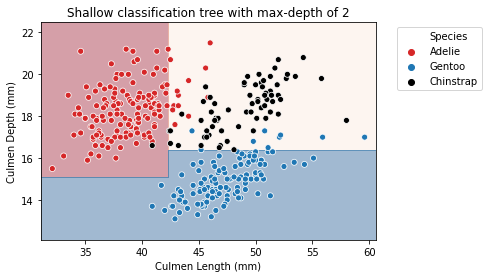

In [7]:
plot_classification(tree_clf, data_clf[data_clf_columns],
                    data_clf[target_clf_column])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
_ = plt.title(f"Shallow classification tree with max-depth of {max_depth}")

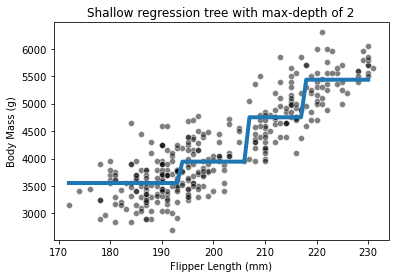

In [9]:
plot_regression(tree_reg, data_reg[data_reg_columns],
                data_reg[target_reg_column])
_ = plt.title(f"Shallow regression tree with max-depth of {max_depth}")

Agora, vamos aumentar o valor do parâmetro `max_depth` para verificar a diferença
observando a função de decisão.

In [10]:
max_depth = 30
tree_clf = DecisionTreeClassifier(max_depth=max_depth)
tree_reg = DecisionTreeRegressor(max_depth=max_depth)

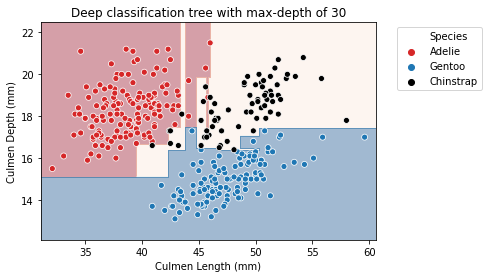

In [11]:
plot_classification(tree_clf, data_clf[data_clf_columns],
                    data_clf[target_clf_column])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
_ = plt.title(f"Deep classification tree with max-depth of {max_depth}")

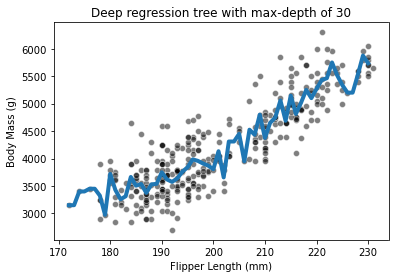

In [12]:
plot_regression(tree_reg, data_reg[data_reg_columns],
                data_reg[target_reg_column])
_ = plt.title(f"Deep regression tree with max-depth of {max_depth}")

Para as configurações de classificação e regressão, observamos que
aumentar a profundidade tornará o modelo de árvore mais expressivo. No entanto, um
árvore muito profunda sobrecarregará os dados de treinamento, criando partições
que são corretos apenas para "outliers" (amostras ruidosas). O `max_depth` é um
dos hiperparâmetros que devem ser otimizados por meio de validação cruzada e
grid-search.

In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth": np.arange(2, 10, 1)}
tree_clf = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid)
tree_reg = GridSearchCV(DecisionTreeRegressor(), param_grid=param_grid)

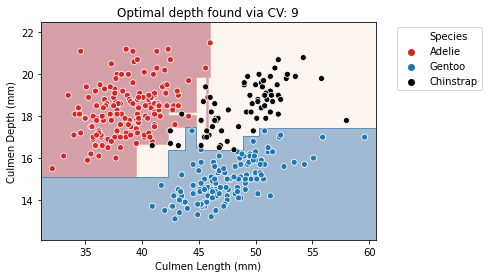

In [14]:
plot_classification(tree_clf, data_clf[data_clf_columns],
                    data_clf[target_clf_column])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
_ = plt.title(f"Optimal depth found via CV: "
              f"{tree_clf.best_params_['max_depth']}")

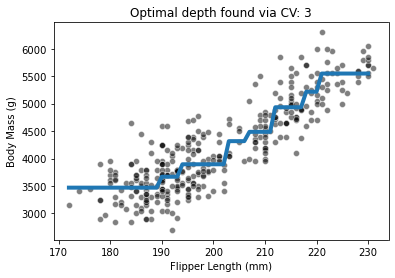

In [15]:
plot_regression(tree_reg, data_reg[data_reg_columns],
                data_reg[target_reg_column])
_ = plt.title(f"Optimal depth found via CV: "
              f"{tree_reg.best_params_['max_depth']}")

Com este exemplo, vemos que não há um único valor que seja ideal
para qualquer conjunto de dados. Assim, este parâmetro deve ser otimizado para cada
aplicativo.

## Outros hiperparâmetros em árvores de decisão

O hiperparâmetro `max_depth` controla a complexidade geral da árvore.
Este parâmetro é adequado partindo do pressuposto de que uma árvore construída é
simétrico. No entanto, não há garantia de que uma árvore será simétrica.
Na verdade, o desempenho estatístico ideal pode ser alcançado aumentando alguns dos
os ramos mais profundos do que alguns outros.

Construiremos um conjunto de dados onde ilustraremos essa assimetria. Nós vamos
gerar um conjunto de dados composto por 2 subconjuntos: um subconjunto onde uma separação clara
deve ser encontrado pela árvore e outro subconjunto onde as amostras de ambos
as aulas serão mistas. Isso implica que uma árvore de decisão precisará de mais divisões
classificar adequadamente as amostras do segundo subconjunto do que do primeiro
subconjunto.

In [16]:
from sklearn.datasets import make_blobs

data_clf_columns = ["Feature #0", "Feature #1"]
target_clf_column = "Class"

# Blobs that will be interlaced
X_1, y_1 = make_blobs(
    n_samples=300, centers=[[0, 0], [-1, -1]], random_state=0)
# Blobs that will be easily separated
X_2, y_2 = make_blobs(
    n_samples=300, centers=[[3, 6], [7, 0]], random_state=0)

X = np.concatenate([X_1, X_2], axis=0)
y = np.concatenate([y_1, y_2])
data_clf = np.concatenate([X, y[:, np.newaxis]], axis=1)
data_clf = pd.DataFrame(
    data_clf, columns=data_clf_columns + [target_clf_column])
data_clf[target_clf_column] = data_clf[target_clf_column].astype(np.int32)

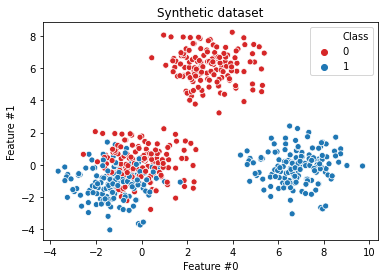

In [17]:
sns.scatterplot(data=data_clf, x=data_clf_columns[0], y=data_clf_columns[1],
                hue=target_clf_column, palette=["tab:red", "tab:blue"])
_ = plt.title("Synthetic dataset")

Vamos primeiro treinar uma árvore de decisão rasa com `max_depth = 2`. Nós gostaríamos
espere que essa profundidade seja o suficiente para separar as bolhas que são fáceis de
separado.

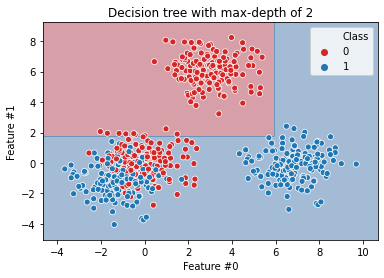

In [18]:
max_depth = 2
tree_clf = DecisionTreeClassifier(max_depth=max_depth)
plot_classification(tree_clf, data_clf[data_clf_columns],
                    data_clf[target_clf_column])
_ = plt.title(f"Decision tree with max-depth of {max_depth}")

Como esperado, vemos que a bolha azul à direita e a bolha vermelha à
top são facilmente separados. No entanto, mais divisões serão necessárias para melhor

Na verdade, vemos aquela mancha vermelha na parte superior e a mancha azul à direita de
o enredo está perfeitamente separado. No entanto, a árvore ainda está cometendo erros
na área onde as bolhas estão misturadas. Vamos checar a árvore
representação.

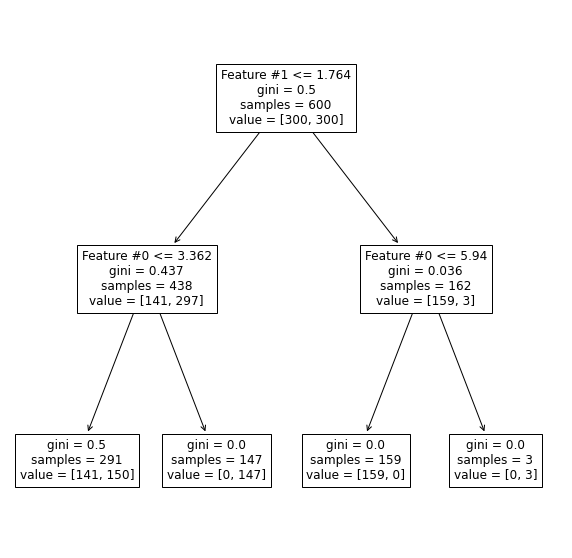

In [19]:
from sklearn.tree import plot_tree

_, ax = plt.subplots(figsize=(10, 10))
_ = plot_tree(tree_clf, ax=ax, feature_names=data_clf_columns)

Vemos que o ramo certo atinge a classificação perfeita. Agora nós
aumente a profundidade para verificar como a árvore crescerá.

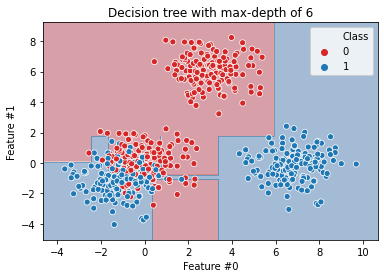

In [20]:
max_depth = 6
tree_clf = DecisionTreeClassifier(max_depth=max_depth)
plot_classification(tree_clf, data_clf[data_clf_columns],
                    data_clf[target_clf_column])
_ = plt.title(f"Decision tree with max-depth of {max_depth}")

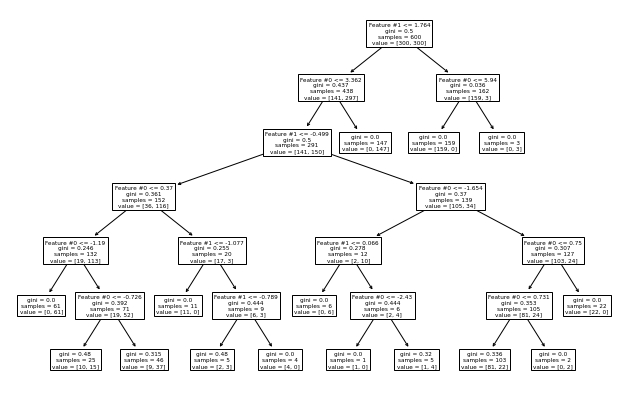

In [21]:
_, ax = plt.subplots(figsize=(11, 7))
_ = plot_tree(tree_clf, ax=ax, feature_names=data_clf_columns)

Como esperado, o galho esquerdo da árvore continua a crescer enquanto não mais
as divisões foram feitas no ramo direito. Corrigir o parâmetro `max_depth` seria
cortar a árvore horizontalmente em um nível específico, mesmo que não
seja mais benéfico que um ramo continue crescendo.

Os hiperparâmetros `min_samples_leaf`,` min_samples_split`,
`max_leaf_nodes`, ou` min_impurity_decrease` permite o crescimento de árvores assimétricas
e aplique uma restrição no nível das folhas ou nós. Vamos verificar o efeito
de `min_samples_leaf`.

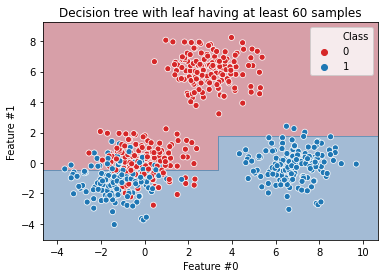

In [22]:
min_samples_leaf = 60
tree_clf = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
plot_classification(tree_clf, data_clf[data_clf_columns],
                    data_clf[target_clf_column])
_ = plt.title(
    f"Decision tree with leaf having at least {min_samples_leaf} samples")

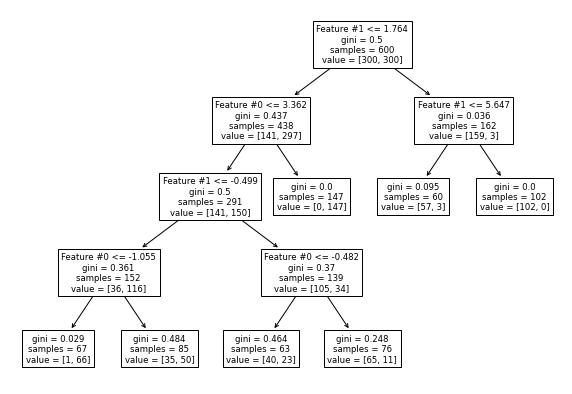

In [23]:
_, ax = plt.subplots(figsize=(10, 7))
_ = plot_tree(tree_clf, ax=ax, feature_names=data_clf_columns)

Este hiperparâmetro permite ter folhas com um número mínimo de amostras
e nenhuma outra divisão será pesquisada de outra forma. Portanto, estes
hiperparâmetros podem ser uma alternativa para corrigir o `max_depth`
hiperparâmetro.